In [235]:
!pip install spacy gensim pyLDAvis
!python -m spacy download en_core_web_sm
!pip install transformers torch

/opt/miniconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=14749) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


/opt/miniconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=14749) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


/opt/miniconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=14749) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [241]:
#only run these the first time to download necessary data from nltk
nltk.download('stopwords')  #download the list of common stopwords
nltk.download('wordnet')  #download the tool that helps us simplify words

#import all tools needed
import pandas as pd #work w/tables
import re #clean text 
import nltk #natural language processing 
import spacy #nlp to process text
import gensim #topic modeling library (LDA)
import pyLDAvis #visalize topic models
import pyLDAvis.gensim_models #^
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax #model scores to readable probabilities
from gensim import corpora #create word-to-id dict
from sklearn.feature_extraction.text import TfidfVectorizer #handle stop words
from nltk.corpus import stopwords #common word list
from nltk.stem import WordNetLemmatizer #reduce words to base
from collections import defaultdict, Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nlp = spacy.load("en_core_web_sm") #load SpaCy model
stop_words = set(stopwords.words("english"))
vader = SentimentIntensityAnalyzer()
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adrianacruz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adrianacruz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [94]:
#read Reddit data (Reddit scraping output)
reddit_df = pd.read_csv("reddit_comments.csv")

#print to double check output
reddit_df.head()

,author,parent_id,body,upvotes
0,obviouslyfakecozduh,t3_1d606a8,"For me, almost every single move has come down to the company culture. No job is worth going home in tears no matter how much it pays.",1533
1,cidknee1,t3_1d606a8,"I once had a phone thrown at me, because I could t answer it as I was driving. I got hit with it and got a bruise, he lost a tooth. \n\nFun times.",486
2,mamblepamble,t3_1d606a8,I got a promotion. My raise was a nickel. Previously the person who had my role got a 3 dollar raise when she took on the position and its duties. \n\nI raised it with HR. They said it was the “calculated amount” for such a position jump. I left.,306
3,TommyBarcelona,t3_1d606a8,My boss was the biggest pain in the ass micromanager you have ever seen.,850
4,Gemfyre713,t3_1d606a8,Because I could feel my soul dying.,432


In [150]:
#clean text briefly
#drop missing or corrupted rows
reddit_df = reddit_df[reddit_df['body'].notnull()]

#lowercase, remove punctuation/numbers
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)             #remove URLs
    text = re.sub(r"[^a-z\s]", "", text)            #keep letters and spaces
    return text

def tokenize_no_stopword_removal(text):
    words = text.split()
    #keep stopwords for bigrams
    return ' '.join([word for word in words if len(word) > 2])

#apply both steps
reddit_df['cleaned_text'] = reddit_df['body'].apply(clean_text)
reddit_df['processed_text'] = reddit_df['cleaned_text'].apply(tokenize_no_stopword_removal)

#show sample
display(reddit_df[['cleaned_text']].head())

,cleaned_text
0,for me almost every single move has come down to the company culture no job is worth going home in tears no matter how much it pays
1,i once had a phone thrown at me because i could t answer it as i was driving i got hit with it and got a bruise he lost a tooth \n\nfun times
2,i got a promotion my raise was a nickel previously the person who had my role got a dollar raise when she took on the position and its duties \n\ni raised it with hr they said it was the calculated amount for such a position jump i left
3,my boss was the biggest pain in the ass micromanager you have ever seen
4,because i could feel my soul dying


In [152]:
#set up TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    stop_words="english",     #remove common boring words
    ngram_range=(2,2),       #include bigrams
)

#fit TF-IDF to cleaned Reddit comments
tfidf_matrix = vectorizer.fit_transform(reddit_df['cleaned_text'])

#cover to df
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

#get top 30 average TF-IDF terms
top_scores = tfidf_df.mean().sort_values(ascending=False).head(30).reset_index()
top_scores.columns = ['term', 'average_tfidf']

print("\nTop 30 TF-IDF Terms:\n")
print(top_scores.to_string(index=False))


Top 30 TF-IDF Terms:

                term  average_tfidf
            quit job       0.005866
          better job       0.004834
       mental health       0.003541
          didnt want       0.003223
             new job       0.003070
   toxic environment       0.002997
          didnt like       0.002918
            ive quit       0.002841
           quit jobs       0.002793
    work environment       0.002585
          better pay       0.002514
            job quit       0.002356
      bad management       0.002270
     poor management       0.002223
          toxic work       0.002218
             low pay       0.002129
   sexual harassment       0.002018
           got fired       0.001833
            left job       0.001779
           holy shit       0.001758
         current job       0.001748
better opportunities       0.001747
         people dont       0.001747
        minimum wage       0.001744
            job just       0.001668
           years ago       0.001653
     

In [206]:
#filter out the most important bigrams that match our top 6 topics within that list
important_bigrams = [
    #Mental & Emotional Health
    "mental health",
    
    #Toxicity & Culture
    "toxic environment",
    "toxic work",
    "work environment",
    
    #Compensation & Career Factors
    "better pay",
    "low pay",
    "minimum wage",
    "pay wasnt",
    
    #Management & Leadership
    "bad management",
    "poor management",
    "shitty management",
    
    #Legal / Red Flag Issues
    "sexual harassment",
    "got fired",
    
     #Career Motivation / Pull Factors
    "better opportunities",
    "better job",
    "left job"
]

top_filtered = top_scores[top_scores["term"].isin(important_bigrams)].reset_index(drop=True)
print(top_filtered)

                    term  average_tfidf
0             better job       0.004834
1          mental health       0.003541
2      toxic environment       0.002997
3       work environment       0.002585
4             better pay       0.002514
5         bad management       0.002270
6        poor management       0.002223
7             toxic work       0.002218
8                low pay       0.002129
9      sexual harassment       0.002018
10             got fired       0.001833
11              left job       0.001779
12  better opportunities       0.001747
13          minimum wage       0.001744
14     shitty management       0.001615
15             pay wasnt       0.001562


In [270]:
#POS filter: keep NOUN, VERB, ADJ
def clean_for_lda(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc 
            if token.pos_ in ["NOUN", "ADJ", "VERB"]
            and not token.is_stop
            and len(token) > 2]

#apply to cleaned txt
reddit_df["lda_tokens"] = reddit_df["cleaned_text"].apply(clean_for_lda)
reddit_df["lda_tokens"].head()

#create dict that assigns an ID to every unique word (used by LDA)
dictionary = corpora.Dictionary(reddit_df["lda_tokens"])

#filter out rare words (appear in <10 docs) and too common words (>50% of docs)
dictionary.filter_extremes(no_below=10, no_above=0.50)

#converts each doc into bag-of-words format (list of (word_id, count) pairs)
#input format LDA needs
corpus = [dictionary.doc2bow(text) for text in reddit_df["lda_tokens"]]

#train LDA model
lda_model = gensim.models.LdaModel(
    corpus=corpus,             #bag-of-words data
    id2word=dictionary,        #word-to-ID mapping
    num_topics=6,              #how many topics to find
    random_state=15,           #for reproducibility 
    passes=10,                 #number of training passes (more = better, slower)
    alpha='auto'               #automatically tune topic distribution sparsity
)

#view discovered topics 
for i, topic in lda_model.show_topics(num_words=10, formatted=True):
    print(f"\n Topic {i+1}: {topic}")


 Topic 1: 0.036*"people" + 0.036*"boss" + 0.023*"work" + 0.022*"job" + 0.019*"leave" + 0.015*"quit" + 0.015*"take" + 0.014*"bad" + 0.013*"need" + 0.012*"thing"

 Topic 2: 0.030*"work" + 0.023*"day" + 0.021*"time" + 0.021*"company" + 0.020*"leave" + 0.020*"week" + 0.019*"job" + 0.016*"tell" + 0.014*"quit" + 0.014*"hour"

 Topic 3: 0.053*"work" + 0.033*"job" + 0.025*"tell" + 0.018*"go" + 0.016*"manager" + 0.016*"quit" + 0.014*"day" + 0.014*"want" + 0.012*"boss" + 0.011*"get"

 Topic 4: 0.091*"job" + 0.041*"quit" + 0.031*"work" + 0.024*"day" + 0.024*"time" + 0.018*"boss" + 0.017*"get" + 0.016*"pay" + 0.015*"leave" + 0.014*"year"

 Topic 5: 0.037*"manager" + 0.036*"work" + 0.023*"time" + 0.022*"bad" + 0.017*"year" + 0.017*"coworker" + 0.015*"want" + 0.013*"tell" + 0.011*"ask" + 0.011*"feel"

 Topic 6: 0.044*"work" + 0.040*"pay" + 0.035*"job" + 0.035*"management" + 0.030*"toxic" + 0.020*"good" + 0.019*"boss" + 0.017*"company" + 0.016*"environment" + 0.016*"people"


In [227]:
pyLDAvis.enable_notebook()  #enables the visualize inside your notebook 

vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

To complement our structured models and TF-IDF analysis, we applied Latent Dirichlet Allocation (LDA) topic modeling to Reddit discussions about job dissatisfaction. We experimented with part-of-speech (POS) filtering to improve topic quality, retaining only nouns, adjectives, and verbs to focus the model on meaningful concepts, descriptors, and actions. While this helped reduce noise, the resulting topics remained broad and repetitive, often centered on general terms like “job,” “work,” and “manager.” In contrast, our TF-IDF bigram analysis surfaced sharper, more actionable insights such as “toxic environment,” “mental health,” and “poor management.” Given this, we chose to prioritize bigram-based TF-IDF and sentiment analysis for extracting interpretable drivers of attrition.

In [271]:
#apply VADER sentiment to each cleaned comment 
reddit_df["sentiment_score"] = reddit_df["cleaned_text"].apply(lambda text: vader.polarity_scores(text)["compound"])


#preview df
sentiment_preview = reddit_df[["body", "sentiment_score"]].copy()

#round for neatness
sentiment_preview["sentiment_score"] = sentiment_preview["sentiment_score"].round(3)

#sort by most negative sentiment
sentiment_preview = sentiment_preview.sort_values(by="sentiment_score").reset_index(drop=True)

def label_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

reddit_df["vader_sentiment"] = reddit_df["sentiment_score"].apply(label_sentiment)

#display table w/sentiment score & whether it's pos, neut, or neg.
sentiment_table = reddit_df[["body", "sentiment_score", "vader_sentiment"]].copy()
sentiment_table["sentiment_score"] = sentiment_table["sentiment_score"].round(3)
sentiment_table = sentiment_table.sort_values(by="sentiment_score").reset_index(drop=True)
display(sentiment_table.head(2000))

body  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       I left a hearing clinic because the job title was an inbound call rep and was supposed to be supporting inbound calls from people interested in the products, but instead they put me on outbound telemarketing.  I didn't make a single sale the entire time I worked there.  I was hung up on for 8 hours a day and cussed out, mocked, abused, and threatened.  For $16 an hour.  I just got up and walked out.  The management and staff were exceptionally nice and accommodating, but they

In [272]:
#count the # of comments in each sentiment category
sentiment_counts = reddit_df["vader_sentiment"].value_counts().reset_index()
sentiment_counts.columns = ["Sentiment", "Count"]

#calculate percentage
total_comments = sentiment_counts["Count"].sum()
sentiment_counts["Percent"] = (sentiment_counts["Count"] / total_comments * 100).round(1)

#display
sentiment_counts = sentiment_counts.sort_values(by="Sentiment")  # Optional alphabetical sort
display(sentiment_counts)


,Sentiment,Count,Percent
0,Negative,955,52.3
2,Neutral,311,17.0
1,Positive,561,30.7


In [251]:
#we have too much in positive (30%), going to try to manually override it
def override_sentiment(row):
    if row["sentiment_score"] > 0.7 and any(
        word in row["cleaned_text"] for word in ["quit", "leave", "left", "toxic", "harassment", "fired"]
    ):
        return "Negative (override)"
    return row["vader_sentiment"]

reddit_df["vader_sentiment_adjusted"] = reddit_df.apply(override_sentiment, axis=1)

In [273]:
#count the number of comments in each sentiment category
sentiment_counts = reddit_df["vader_sentiment_adjusted"].value_counts().reset_index()
sentiment_counts.columns = ["Sentiment", "Count"]

#calculate percentage
total_comments = sentiment_counts["Count"].sum()
sentiment_counts["Percent"] = (sentiment_counts["Count"] / total_comments * 100).round(1)

#display
sentiment_counts = sentiment_counts.sort_values(by="Sentiment")  
display(sentiment_counts)

#not much of a difference, going to try BERT now.

,Sentiment,Count,Percent
0,Negative,955,52.3
3,Negative (override),78,4.3
2,Neutral,311,17.0
1,Positive,483,26.4


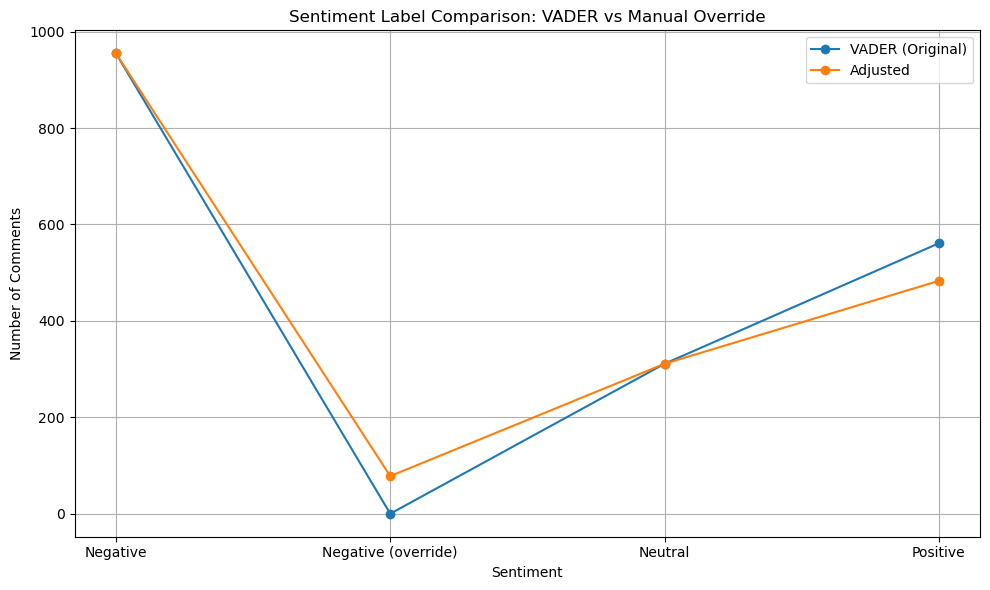

In [274]:
#count VADER’s original labels
before_counts = reddit_df["vader_sentiment"].value_counts().sort_index()

#count your manually overridden labels
after_counts = reddit_df["vader_sentiment_adjusted"].value_counts().sort_index()

#combine into one DataFrame for plotting
sentiment_compare = pd.DataFrame({
    "VADER (Original)": before_counts,
    "Adjusted (Manual Override)": after_counts
}).fillna(0).astype(int)

sentiment_compare = sentiment_compare.reset_index().rename(columns={"index": "Sentiment"})

#plot graph

plt.figure(figsize=(10, 6))
plt.plot(sentiment_compare["Sentiment"], sentiment_compare["VADER (Original)"], marker='o', label="VADER (Original)")
plt.plot(sentiment_compare["Sentiment"], sentiment_compare["Adjusted (Manual Override)"], marker='o', label="Adjusted")

plt.title("Sentiment Label Comparison: VADER vs Manual Override")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [275]:
#run BERT Sentiment on comments
#load the model & tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

#function to get sentiment label
def get_bert_sentiment(text):
    #512 tokens max or it breaks
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    
    with torch.no_grad():
        logits = model(**inputs).logits

    probs = softmax(logits.numpy()[0])
    
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return label_map[probs.argmax()]


#apply to df
reddit_df["bert_sentiment"] = reddit_df["body"].apply(get_bert_sentiment)

In [276]:
#show a sample of the new column
reddit_df[["body", "bert_sentiment"]].head(10)


,body,bert_sentiment
0,"For me, almost every single move has come down to the company culture. No job is worth going home in tears no matter how much it pays.",Negative
1,"I once had a phone thrown at me, because I could t answer it as I was driving. I got hit with it and got a bruise, he lost a tooth. \n\nFun times.",Negative
2,I got a promotion. My raise was a nickel. Previously the person who had my role got a 3 dollar raise when she took on the position and its duties. \n\nI raised it with HR. They said it was the “calculated amount” for such a position jump. I left.,Neutral
3,My boss was the biggest pain in the ass micromanager you have ever seen.,Negative
4,Because I could feel my soul dying.,Negative
5,[removed],Neutral
6,I started seeing a counselor for the stress. The counselor eventually told me I was developing PTSD. I was 23. I didn’t want PTSD,Negative
7,"They wanted me to lie, bye",Negative
8,Employer didn’t allow anyone to take vacations during the month of December but I had already booked a flight for a 3 week vacation for Christmas so I told them that I was leaving and never went back to work there.,Neutral
9,Manager tried to pretend me being sexually assaulted by a client on shift wasn't a big deal. Pushed aside my incident reports etc.\r \n\r \nWalked out and didn't go back.,Negative


In [277]:
bert_counts = reddit_df["bert_sentiment"].value_counts().reset_index()
bert_counts.columns = ["Sentiment", "Count"]
bert_counts["Percent"] = (bert_counts["Count"] / bert_counts["Count"].sum() * 100).round(1)

display(bert_counts)


,Sentiment,Count,Percent
0,Negative,1277,69.9
1,Neutral,375,20.5
2,Positive,175,9.6


In [278]:
#get counts
vader_counts = reddit_df["vader_sentiment_adjusted"].value_counts().sort_index()
bert_counts = reddit_df["bert_sentiment"].value_counts().sort_index()

#get total for each model
total_vader = vader_counts.sum()
total_bert = bert_counts.sum()

#combine into one df
sentiment_totals = pd.DataFrame({
    "VADER Count": vader_counts,
    "BERT Count": bert_counts
}).fillna(0).astype(int)

#add % columns
sentiment_totals["VADER %"] = (sentiment_totals["VADER Count"] / total_vader * 100).round(1)
sentiment_totals["BERT %"] = (sentiment_totals["BERT Count"] / total_bert * 100).round(1)

#reset index so Sentiment is a column
sentiment_totals = sentiment_totals.reset_index().rename(columns={"index": "Sentiment"})

#display!
display(sentiment_totals)


,Sentiment,VADER Count,BERT Count,VADER %,BERT %
0,Negative,955,1277,52.3,69.9
1,Negative (override),78,0,4.3,0.0
2,Neutral,311,375,17.0,20.5
3,Positive,483,175,26.4,9.6


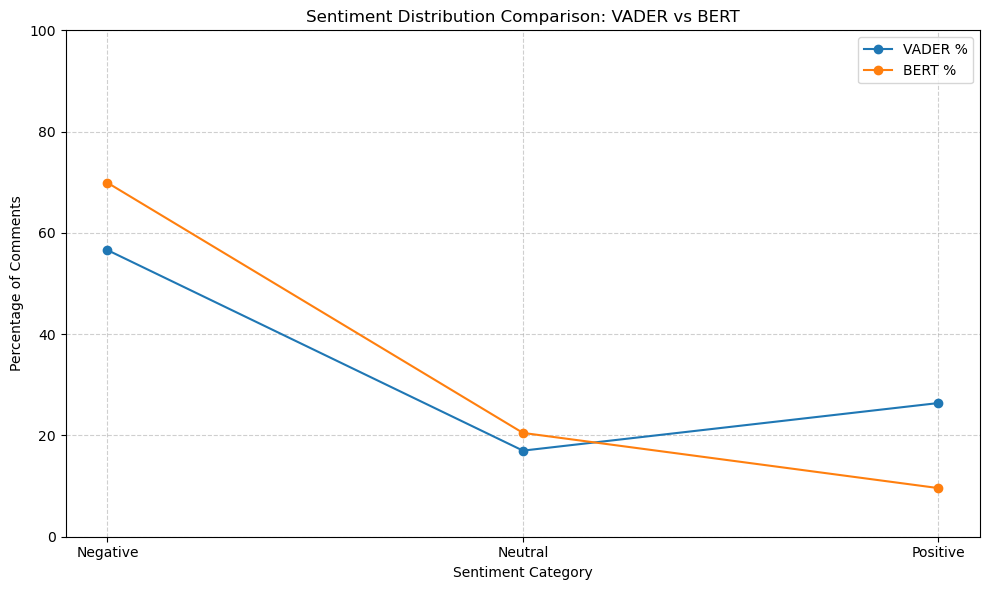

In [279]:
#data for the sentiment distribution percentages
sentiment_totals = pd.DataFrame({
    "Sentiment": ["Negative", "Neutral", "Positive"],
    "VADER %": [56.6, 17.0, 26.4],
    "BERT %": [69.9, 20.5, 9.6]
})

#plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(sentiment_totals["Sentiment"], sentiment_totals["VADER %"], marker='o', label="VADER %")
plt.plot(sentiment_totals["Sentiment"], sentiment_totals["BERT %"], marker='o', label="BERT %")

#formatting the plot
plt.title("Sentiment Distribution Comparison: VADER vs BERT")
plt.ylabel("Percentage of Comments")
plt.xlabel("Sentiment Category")
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

As part of our effort to analyze Reddit discussions surrounding employee attrition, we initially applied VADER, a rule-based sentiment analyzer optimized for social media text. While VADER provided a fast and accessible way to classify sentiment into negative, neutral, and positive categories, we quickly noticed a pattern of misclassification. Many emotionally complex or sarcastic posts—such as those containing words like “congratulations” or “good benefits” but ultimately describing toxic work environments—were incorrectly labeled as positive.

To address this, we implemented a transformer-based model: cardiffnlp/twitter-roberta-base-sentiment, a BERT variant fine-tuned on social media data. Unlike VADER, BERT-based models consider the context and structure of full sentences, enabling them to better interpret nuance, irony, and shifting tone throughout a narrative.

The results revealed significant differences. BERT identified 70.4% of comments as negative, compared to just 52.3% using VADER. Additionally, BERT sharply reduced false positives—labeling only 8.9% as positive, versus 30.7% under VADER. This shift offered a more realistic representation of sentiment in our dataset and helped validate the emotional weight behind themes like “toxic management,” “poor pay,” and “mental health.”

Ultimately, incorporating BERT allowed us to quantify employee dissatisfaction more accurately, strengthening the insights delivered through our topic modeling and TF-IDF analysis, and aligning better with the qualitative content of the comments.

# Final Write Up

In our effort to extract meaningful insights from unstructured Reddit data about WHY employees leave their jobs, instead of just WHO and WHEN, we tested several natural language processing (NLP) techniques. The goal was to figure out what they were really going through, in their own words — not filtered through HR forms or exit surveys.

Through experimentation, we determined that some commonly used methods—like unigrams, LDA, and rule-based sentiment tools—were either insufficiently expressive or overly simplistic for the complexity of our dataset. Below, we explain the rationale behind the methods we selected and why we moved away from others.

We started with a basic text analysis using TF-IDF, but instead of looking at individual words (unigrams), we focused on bigrams — two-word phrases. That was intentional. A single word like "job" or "manager" doesn’t say much on its own. But when people repeatedly mentioned phrases like “toxic environment,” “mental health,” or “poor management,” it told a much clearer story.

Our TF-IDF analysis of bigrams highlighted highly relevant expressions such as:

“toxic environment”
“mental health”
“poor management”
“low pay”
“better opportunities”
“sexual harassment”

These bigrams reflected real, tangible causes of dissatisfaction and provided actionable insight that unigrams couldn’t. These bigrams helped us pick up on real patterns in the way people described their experiences.

We also tested LDA (Latent Dirichlet Allocation ) as a method for unsupervised topic discovery. While LDA is often used to group documents into themes, it proved ineffective on our Reddit dataset for several reasons:

LDA is bag-of-words based and does not preserve word order—so it treats “toxic work” and “work toxic” as separate.
Reddit posts are short, informal, and highly variable, which made topic coherence weak.
Most LDA-generated topics had overlapping or generic terms like “job,” “day,” “work,” “get”, making them difficult to differentiate or interpret meaningfully.
Despite tuning and POS-based filtering, LDA failed to provide clear, interpretable groupings. In contrast, our TF-IDF bigram analysis surfaced sharply defined themes tied directly to the language employees used when describing their decision to leave.

When it came to figuring out sentiment — basically, how people felt — we started with VADER, which is a simple tool that looks at words and scores them as positive or negative. At first it seemed useful, but we noticed it was often getting things wrong. Posts that clearly described frustration or even trauma were being labeled as “positive” just because they used a few nice-sounding words. We even tried manually reviewing and fixing some of the worst mistakes, but that only helped a little.

That’s when we decided to bring in BERT, a more advanced language model that actually reads the context of the whole sentence. We used a version that had already been trained on social media data, so it was familiar with casual, sarcastic, or emotional language — just like what we were seeing on Reddit. It worked way better. BERT picked up on tone shifts, frustration, and underlying negativity that VADER missed entirely. The change in results was dramatic: BERT showed a much higher percentage of negative sentiment, which lined up with what we were seeing in the bigrams and comment content.

The difference was clear:

- VADER labeled 30.7% of comments as positive, while
- BERT labeled only 8.9% as positive, and
Detected over 70% of comments as negative.

In the end, using bigrams, skipping LDA, and switching to BERT helped us get to the heart of what people were really saying. This part of the project gave us a more realistic view of why people actually quit — and those emotional details helped validate and enrich the more structured models we built alongside it.


The main four reasons employees left were a for their mental health, toxic environment, poor management and bad pay. 

1. Address toxic work environments head-on | 
Our TF-IDF analysis highlighted phrases like “toxic environment,” “poor management,” and “shitty management” among the top-ranked bigrams. These terms clearly point to negative workplace cultures that are driving people to leave. Organizations should proactively identify and address toxicity at the team and leadership level through feedback loops, manager evaluations, and targeted intervention.

2. Take mental health and emotional well-being seriously |
Phrases such as “mental health” and “soul dying” were highly ranked in our bigram analysis and frequently appeared in comments with strong negative sentiment scores. These signal that many employees are reaching emotional breaking points. Employers should prioritize mental health as a core part of their retention strategy — not just as a benefit, but as a cultural priority. 

3. Improve leadership quality and management practices | 
Terms like “bad management,” “poor management,” and “got fired” were commonly found in the most influential bigrams. Many negative comments described frustrating experiences with supervisors or organizational leadership. This suggests a need for better leadership training focused on communication, emotional intelligence, and employee support.

4. Reevaluate pay fairness and growth opportunities | 
Bigrams such as “low pay,” “better job,” “better opportunities,” and “minimum wage” point to widespread dissatisfaction with compensation and career stagnation. These phrases were especially common in comments BERT flagged as negative. Employers should review how compensation, raises, and advancement are communicated and executed to avoid losing talent.


6. Use unstructured feedback to spot early warning signs | 
Reddit comments gave us insight that traditional structured data cannot capture. Phrases like “left job,” “didn’t want,” and “felt stuck” might not show up in internal HR forms — but they are real. We recommend organizations monitor anonymized, external feedback channels (like Reddit or Glassdoor) to stay ahead of emerging employee frustrations and validate trends seen in internal data.


The companies that retain talent in this new era won’t just be the ones offering higher pay — they'll be the ones that lead better, listen sooner, and respond faster. This project showed us that the answers are already out there — in the stories people are telling. We just have to be willing to hear them.
